In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
#Creiamo un tf.data.Dataset a partire dalle immagini nella directory su disco per il training set e il test set.
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode='int'
)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    labels='inferred',
    label_mode='int'
)

Found 16932 files belonging to 4 classes.
Found 4233 files belonging to 4 classes.


In [3]:
#image_batch è un tensore della forma (32, 256, 256, 3) .
#Questo è un batch di 32 immagini di forma 256x256x3. 
#Il label_batch è un tensore della forma (32,4) cioè in ogni batch ci sono 32 immagini e le etichette sono 4
for image_batch, labels_batch in train_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32,)


Xception deve ricevere come input immagini di dimensione (224,224,3), occorre dunque modificare la dimensione delle immagini. Inoltre i pixel devono assumee valori tra [-1, +1] e non da 0 a 255, occorre quindi anche eseguire una normalizzazione

In [4]:
from tensorflow.keras import layers

resize_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(299, 299),
  layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)

])

def prepare(ds):
    #Resize
    ds = ds.map(lambda x, y: (resize_rescale(x),y))
    return ds

train_set = prepare(train_set)
test_set = prepare(test_set)


In [5]:
#Verifichiammo che sia avvenuto il resizing 
for image_batch, labels_batch in train_set:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 299, 299, 3)
(32,)


# TRANSFER LEARNING 

In [6]:
#Creiamo il modello base considerando Xception pre-addestrato su ImageNet.
#Non consideriamo gli ultimi layer che sono finalizzati agli obiettivo di classificazione di Imagenet
base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet')

In [7]:
#Il base_model si comporta quindi come un estrattore di featues,
#In particolare estrae dalle immagini 299x299x3 in blocchi 10x10x2048 di features. 
image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 2048)


In [8]:
#Congeliamo il resto dei layer impedendone così l'aggiornamento durante l'addestramento.
base_model.trainable = False

In [9]:
#Ora a partire dal blocco di features, usiamo un layer tf.keras.layers.GlobalAveragePooling2D,
#facendo una media in una finestra 10x10, per generare le predizioni finali poichè ci consente di
#convertire le features in un singolo vettore di 2048 elementi per immagine.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [10]:
#Definiamo uno strato fully-connected per convertire queste features in una singola predizione.
prediction_layer = tf.keras.layers.Dense(4, activation='relu')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [11]:
#Costruiamo il modello considerando quanto definito precedentemente
inputs = tf.keras.Input(shape=(299, 299, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
#Compiliamo il modello
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
_________________________________________________________________


In [13]:
#Addestriamo il modello sul train set
history = model.fit(train_set, epochs=1)

530/530 [==============================] - 3441s 6s/step - loss: 0.7488 - accuracy: 0.7242


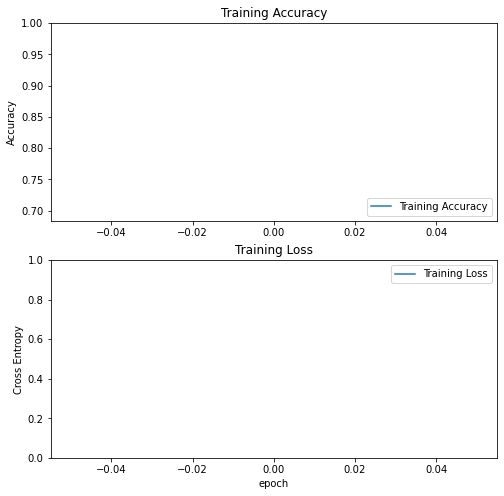

In [14]:
import matplotlib.pyplot as plt

#Analizziamo l'andamento dell'addestramento
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
#Valutiamo le prestazioni del modello sul test set
loss_test, accuracy_test = model.evaluate(test_set)
print('Test accuracy :', accuracy_test)

133/133 [==============================] - 843s 6s/step - loss: 0.6529 - accuracy: 0.7879
Test accuracy : 0.7878572940826416


# FINE TUNING 

Un modo per incrementare le performance è eseguire fine-tuning, dove nel processo di training si 'aggiustano' i pesi degli ultimi layers così da specializzare la rete ancor di più al nostro dataset.

In [17]:
#'Scongeliamo' il base_model in modo da non addestrare solo i layer più in basso.
base_model.trainable = True

num_layers = len(base_model.layers)
num_layers

132

In [18]:
#Scegliamo di addestrare il modello solo a partire dal centesimo layer in su
#quindi congeliamo tutti i layer precedenti.
finetune = 100
for layer in base_model.layers[:finetune]:
    layer.trainable =  False

In [19]:
#Ricompiliamo il modello.
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = 'adam',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 9,486,540
Non-trainable params: 11,383,136
_________________________________________________________________


In [20]:
#Continuiamo con l'addestramento
finetune_epochs = 1
total_epochs =  1 + finetune_epochs

history_fine = model.fit(train_set, epochs=total_epochs, initial_epoch=history.epoch[-1])
acc += history_fine.history['accuracy']
loss += history_fine.history['loss']

Epoch 1/2
530/530 [==============================] - 5172s 10s/step - loss: 0.9929 - accuracy: 0.5583
Epoch 2/2
530/530 [==============================] - 5171s 10s/step - loss: 0.5668 - accuracy: 0.7724


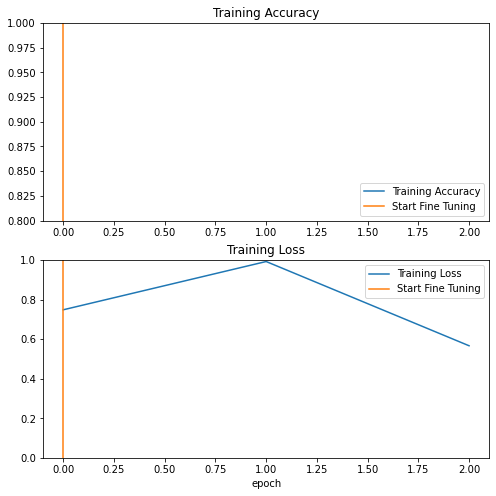

In [21]:
#Analizziamo l'andamento dell'addestramento
initial_epochs = 1
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')

plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()


In [22]:
#Valutazione del modello sul test set dopo il fine tuning
loss_test_fine, accuracy_test_fine = model.evaluate(test_set)
print('Test accuracy :', accuracy_test_fine)

133/133 [==============================] - 833s 6s/step - loss: 0.2794 - accuracy: 0.8996
Test accuracy : 0.8995984196662903


Ripetiamo il transfer learning e il fine tuning eseguendo più epoche

# TRANSFER LEARNING con 5 epoche

In [9]:
#Creiamo il modello base considerando Xception pre-addestrato su ImageNet.
#Non consideriamo gli ultimi layer che sono finalizzati agli obiettivo di classificazione di Imagenet
base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet')

In [10]:
#Il base_model si comporta quindi come un estrattore di featues,
#In particolare estrae dalle immagini 299x299x3 in blocchi 10x10x2048 di features. 
image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 2048)


In [11]:
#Congeliamo il resto dei layer impedendone così l'aggiornamento durante l'addestramento.
base_model.trainable = False

In [12]:
#Ora a partire dal blocco di features, usiamo un layer tf.keras.layers.GlobalAveragePooling2D,
#facendo una media in una finestra 10x10, per generare le predizioni finali poichè ci consente di
#convertire le features in un singolo vettore di 2048 elementi per immagine.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [13]:
#Definiamo uno strato fully-connected per convertire queste features in una singola predizione.
prediction_layer = tf.keras.layers.Dense(4, activation='relu')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [14]:
#Costruiamo il modello considerando quanto definito precedentemente
inputs = tf.keras.Input(shape=(299, 299, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
#Compiliamo il modello
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
_________________________________________________________________


In [16]:
#Addestriamo il modello sul train set
history = model.fit(train_set, epochs=5)

Epoch 1/5
530/530 [==============================] - 3395s 6s/step - loss: 0.9517 - accuracy: 0.5651
Epoch 2/5
530/530 [==============================] - 3360s 6s/step - loss: 0.8197 - accuracy: 0.6010
Epoch 3/5
530/530 [==============================] - 3359s 6s/step - loss: 0.7898 - accuracy: 0.6077
Epoch 4/5
530/530 [==============================] - 3358s 6s/step - loss: 0.7720 - accuracy: 0.6102
Epoch 5/5
530/530 [==============================] - 3351s 6s/step - loss: 0.7585 - accuracy: 0.6130


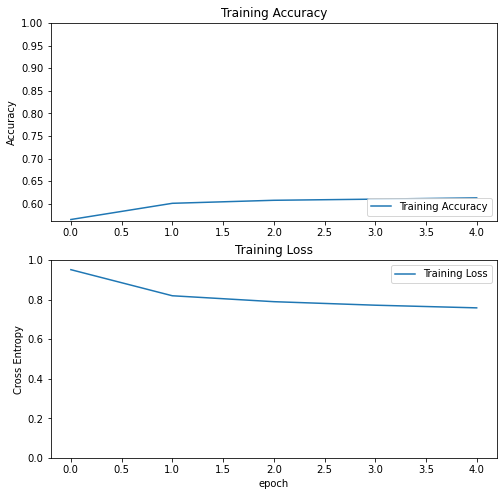

In [17]:
import matplotlib.pyplot as plt

#Analizziamo l'andamento dell'addestramento
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [18]:
#Valutiamo le prestazioni del modello sul test set
loss_test, accuracy_test = model.evaluate(test_set)
print('Test accuracy :', accuracy_test)

133/133 [==============================] - 847s 6s/step - loss: 0.7831 - accuracy: 0.6003
Test accuracy : 0.6002835035324097


# FINE TUNING con 5 epoche

In [19]:
#'Scongeliamo' il base_model in modo da non addestrare solo i layer più in basso.
base_model.trainable = True

num_layers = len(base_model.layers)
num_layers

132

In [20]:
#Scegliamo di addestrare il modello solo a partire dal centesimo layer in su
#quindi congeliamo tutti i layer precedenti.
finetune = 100
for layer in base_model.layers[:finetune]:
    layer.trainable =  False

In [21]:
#Ricompiliamo il modello.
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = 'adam',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 20,869,676
Trainable params: 9,486,540
Non-trainable params: 11,383,136
_________________________________________________________________


In [24]:
#Continuiamo con l'addestramento
finetune_epochs = 5
total_epochs =  5 + finetune_epochs

history_fine = model.fit(train_set, epochs=total_epochs, initial_epoch=history.epoch[-1])
acc += history_fine.history['accuracy']
loss += history_fine.history['loss']

Epoch 5/10
530/530 [==============================] - 5106s 10s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 6/10
530/530 [==============================] - 5072s 10s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 7/10
530/530 [==============================] - 5055s 10s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 8/10
530/530 [==============================] - 5055s 10s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 9/10
530/530 [==============================] - 5053s 10s/step - loss: 1.3863 - accuracy: 0.1724
Epoch 10/10
530/530 [==============================] - 5062s 10s/step - loss: 1.3863 - accuracy: 0.1724


In [25]:
#Valutazione del modello sul test set dopo il fine tuning
loss_test_fine, accuracy_test_fine = model.evaluate(test_set)
print('Test accuracy :', accuracy_test_fine)

133/133 [==============================] - 814s 6s/step - loss: 1.3863 - accuracy: 0.1647
Test accuracy : 0.16465863585472107
